<a href="https://colab.research.google.com/github/DLProjectTextGeneration/TextGeneration/blob/code/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load the packages**

In [ ]:
import os
import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RNN
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

# **Data import**

We load the song lyrics of Britney Spear's songs. The file is a text file that you can download from the **data** folder on our github : 

1.   Click on this link : https://github.com/DLProjectTextGeneration/TextGeneration/blob/main/Data/britney-spears.txt
2.   Right-click on the *raw* button on the top right corner of the page and select *download the linked file*

Now that you have dowloaded the data, you can import it with the following chunk.

If you don't want to train the models you will also need to import the files in the **weights** folder (https://github.com/DLProjectTextGeneration/TextGeneration/tree/main/Weights).


In [ ]:
uploaded = files.upload()

Saving britney-spears.txt to britney-spears (2).txt
Saving baseline-improvement-britney-36-0.4864_50_128.hdf5 to baseline-improvement-britney-36-0.4864_50_128 (1).hdf5
Saving baseline-improvement-britney-clean-40-0.3835_50_128.hdf5 to baseline-improvement-britney-clean-40-0.3835_50_128 (1).hdf5


In [ ]:
data = open('britney-spears.txt','r')
britney = data.read()
data.close()

We can take a look at the data.

In [ ]:
print(britney[0:1003])

They say get ready for the revolution
I think it's time we find some sorta solution
Somebody's caught up in the endless pollution
They need to wake up, stop living illusions I know you need to hear this
Why won't somebody feel this
This is my wish that we all feel connected
This is my wish that nobodies neglected Be like a rocket baby
Be like a rocket Take off
Just fly, away (ay, ay)
To find your space Take off
Just fly, away (ay, ay)
To find your place Take off You know what they say about mixing the races
And in the end we got the same faces
My mama told me got love yourself first
And if you disagree, get off this damn earth I want to feel connected
Don't want to be neglected
This is my wish that we all find our places
This is my wish that we all escalate (yeah) Be like a rocket baby
Be like a rocket Take off
Just fly, away (ay, ay)
To find your space Take off
Just fly, away (ay, ay)
To find your space Take off
Just fly, away (ay, ay)
To find your space Take off
Just fly, away (ay, a

# **1. Generating text from the raw data**



## **Data processing**

We now associate to each character an integer. For example :

* ' \n ' --> 0
* ' ' --> 1
* ' ! ' --> 2

We have 76 unique different characters. Hence, our text is now a sequence of integer from 0 to 75.






In [ ]:
characters = sorted(list(set(britney)))

n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

vocab_size = len(characters)
print('Number of unique characters: ', vocab_size)
print(characters)

Number of unique characters:  76
['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '6', '7', '8', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We then extract all the possible sequences of 100 characters from our text and we store them into a vector **X**. For each sequence, the follow up character (the target) is stored into another vector **Y**.

In [ ]:
X = []   
Y = []  
length = len(britney)
seq_length = 100   

for i in range(0, length - seq_length, 1):
    sequence = britney[i:i + seq_length]
    label = britney[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])
    
print('Number of extracted sequences:', len(X))

Number of extracted sequences: 135187


In [ ]:
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

X_modified.shape, Y_modified.shape

((135187, 100, 1), (135187, 76))

## **Model creation and training**

We create our model and then we will train our model. 

In [ ]:
model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

If you already have downloaded the file (https://github.com/DLProjectTextGeneration/TextGeneration/blob/main/Weights/baseline-improvement-britney-36-0.4864_50_128.hdf5) in the **weights** folder, you don't need to run the following code and go directly to the next section (Generating text).

We added checkpoints to save the model weights and load it again if we want to add epochs afterwards.

In [ ]:
filepath="/content/training_checkpoints/baseline-improvement-britney-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_modified, Y_modified, epochs=50, batch_size=128, callbacks = callbacks_list)

Epoch 1/50
1057/1057 [==============================] - 74s 68ms/step - loss: 3.1102

Epoch 00001: loss improved from inf to 2.96636, saving model to /content/training_checkpoints/baseline-improvement-britney-01-2.9664.hdf5
Epoch 2/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.7605

Epoch 00002: loss improved from 2.96636 to 2.71115, saving model to /content/training_checkpoints/baseline-improvement-britney-02-2.7112.hdf5
Epoch 3/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.5356

Epoch 00003: loss improved from 2.71115 to 2.48208, saving model to /content/training_checkpoints/baseline-improvement-britney-03-2.4821.hdf5
Epoch 4/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.2882

Epoch 00004: loss improved from 2.48208 to 2.23253, saving model to /content/training_checkpoints/baseline-improvement-britney-04-2.2325.hdf5
Epoch 5/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.0415

Epoch 

## **Generating text**

Run this chunk to load the model we trained that you can download here : https://github.com/DLProjectTextGeneration/TextGeneration/blob/main/Weights/baseline-improvement-britney-36-0.4864_50_128.hdf5 

In [ ]:
filename = "/content/baseline-improvement-britney-36-0.4864_50_128.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

We generate a random start from our initial text.

In [ ]:
start = np.random.randint(0, len(X)-1) 

string_mapped = list(X[start])

full_string = [n_to_char[value] for value in string_mapped]

print("Seed:")
print("\"", ''.join(full_string), "\"")

Seed:
" them candles hanging
Hanging from the ceiling low
We use our bodies to make our own videos
Put on ou "


We generate the 400 following characters.


In [ ]:
for i in range(400):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    full_string.append(n_to_char[pred_index])
    
    string_mapped.append(pred_index)  
    string_mapped = string_mapped[1:len(string_mapped)] 

We combine and print the text.

In [ ]:
txt=""
for char in full_string:
    txt = txt+char

print(start)
print(txt)

96211
them candles hanging
Hanging from the ceiling low
We use our bodies to make our own videos
Put on our music that makes us go fucking crazy, oh
Go crazy, oh
Like a slumber party
Like a slumber party Like a slumber party Lo, n-no, no, you and I, I, I
We ain't gonna sleep tonight 'Cause we got them candles hanging
Hanging from the ceiling low
We use our bod'eves downa tpas it to
What would it have forerer Baby, I'm so into you
You're toxitg that she's sorp lys bry you, I wenla see what I'leel  lite


First, we can notice that the prediction has the same structure as the raw text. We can see that some words make sens (crazy, baby, party, ...) and others don't (forerer, toxitg, lys, ...). Above all, some sentences actually make sens : "We ain't gonna sleep tonight". Finaly, we remark some repetitions but in our case it is rather normal because we trained our model with song lyrics and it contains repetitions. 

We are happy with our model but we think that we can create better by removing the punctuation for example. But first we will choose a fixed start in order to compare the two models.

In [ ]:
start = 40560

string_mapped = list(X[start])

full_string = [n_to_char[value] for value in string_mapped]

print("Seed:")
print("\"", ''.join(full_string), "\"")

Seed:
" And scream and shout and let it out
We saying oh wee oh wee oh wee oh
We saying oh wee oh wee oh wee "


In [ ]:
for i in range(400):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    full_string.append(n_to_char[pred_index])
    
    string_mapped.append(pred_index)  
    string_mapped = string_mapped[1:len(string_mapped)] 

txt=""
for char in full_string:
    txt = txt+char

print(start)
print(txt)

40560
And scream and shout and let it out
We saying oh wee oh wee oh wee oh
We saying oh wee oh wee oh wee oh
I wanna scream and shout and let it all out
And scream and shout and let it all out
And scream and shou and let it all out
And scream and shou and let it all out
And scream and shout and let it out
We saying oh wee oh wee oh wee oh
Wou are now now rocking with Will I Am and Britney bitch Oh yeah..
Oh yeah..
Oh yeah..
Bni: We will, we will rock you! Britney:
We! I said: All:
We will, we will ro


# **2. Generating text from clean data**

## **Data cleaning**

As we explained earlier we trained another model with cleaned data : 



1.   Convert to lower case 
2.   Remove the punctuation



In [ ]:
def convert_text_to_lowercase(df):
    df = df.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df):
    df = df.replace('\n', ' ')
    df = df.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df = df.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df


def text_cleaning(df):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = df.lower()
    df = remove_punctuation(df)
    return df



In [ ]:
britney = text_cleaning(britney)

print(britney[0:1003])

they say get ready for the revolution i think it's time we find some sorta solution somebody's caught up in the endless pollution they need to wake up, stop living illusions i know you need to hear this why won't somebody feel this this is my wish that we all feel connected this is my wish that nobodies neglected be like a rocket baby be like a rocket take off just fly, away (ay, ay) to find your space take off just fly, away (ay, ay) to find your place take off you know what they say about mixing the races and in the end we got the same faces my mama told me got love yourself first and if you disagree, get off this damn earth i want to feel connected don't want to be neglected this is my wish that we all find our places this is my wish that we all escalate (yeah) be like a rocket baby be like a rocket take off just fly, away (ay, ay) to find your space take off just fly, away (ay, ay) to find your space take off just fly, away (ay, ay) to find your space take off just fly, away (ay, a

## **Data processing**

We now only have 50 different characters

In [ ]:
characters = sorted(list(set(britney)))

n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

vocab_size = len(characters)
print('Number of unique characters: ', vocab_size)
print(characters)

Number of unique characters:  50
[' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '6', '7', '8', ':', ';', '?', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
X = []   
Y = []  
length = len(britney)
seq_length = 100   

for i in range(0, length - seq_length, 1):
    sequence = britney[i:i + seq_length]
    label = britney[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])
    
print('Number of extracted sequences:', len(X))

Number of extracted sequences: 135187


In [ ]:
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

X_modified.shape, Y_modified.shape

((135187, 100, 1), (135187, 50))

## **Model creation and training**

In [ ]:
model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

Same a above, now that you have created the model you don't need to train it again. You can go directly to the following section and load the file (https://github.com/DLProjectTextGeneration/TextGeneration/blob/main/Weights/baseline-improvement-britney-clean-40-0.3835_50_128.hdf5).

In [ ]:
filepath="/content/training_checkpoints/baseline-improvement-britney-clean-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_modified, Y_modified, epochs=50, batch_size=128, callbacks = callbacks_list)

Epoch 1/50
1057/1057 [==============================] - 74s 68ms/step - loss: 2.8817

Epoch 00001: loss improved from inf to 2.74098, saving model to /content/training_checkpoints/baseline-improvement-britney-clean-01-2.7410.hdf5
Epoch 2/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.4613

Epoch 00002: loss improved from 2.74098 to 2.37931, saving model to /content/training_checkpoints/baseline-improvement-britney-clean-02-2.3793.hdf5
Epoch 3/50
1057/1057 [==============================] - 71s 67ms/step - loss: 2.1218

Epoch 00003: loss improved from 2.37931 to 2.05692, saving model to /content/training_checkpoints/baseline-improvement-britney-clean-03-2.0569.hdf5
Epoch 4/50
1057/1057 [==============================] - 71s 67ms/step - loss: 1.8372

Epoch 00004: loss improved from 2.05692 to 1.79641, saving model to /content/training_checkpoints/baseline-improvement-britney-clean-04-1.7964.hdf5
Epoch 5/50
1057/1057 [==============================] - 71s 67ms/ste

## **Generating text**

In [ ]:
filename = "/content/baseline-improvement-britney-clean-40-0.3835_50_128.hdf5" # link to find the file : https://github.com/DLProjectTextGeneration/TextGeneration/blob/main/Weights/baseline-improvement-britney-clean-40-0.3835_50_128.hdf5
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
start = 40560

string_mapped = list(X[start])

full_string = [n_to_char[value] for value in string_mapped]

print("Seed:")
print("\"", ''.join(full_string), "\"")

Seed:
" and scream and shout and let it out we saying oh wee oh wee oh wee oh we saying oh wee oh wee oh wee "


In [ ]:
for i in range(400):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    full_string.append(n_to_char[pred_index])
    
    string_mapped.append(pred_index)  
    string_mapped = string_mapped[1:len(string_mapped)] 

In [ ]:
txt=""
for char in full_string:
    txt = txt+char

print(start)
print(txt)

40560
and scream and shout and let it out we saying oh wee oh wee oh wee oh we saying oh wee oh wee oh wee oh i wanna scream and shout and let it all out and scream and shout and let it out we saying oh wee oh wee oh wee oh you are now now rocking with will i am and britney bitch all around the world, pretty girls jump the liness  thay seel pe prcsio' and you niw me on my radar (on my radar) on my radar got you on my radar got you on my radar got you on my radar got you on my radar got you on my radar


For the second model, we were able to reach a lower loss : 0.3835 instead of 0.4864. Indeed, the second model is more accurate than the first one. However, in the second one we lose the struture of a song lyric.

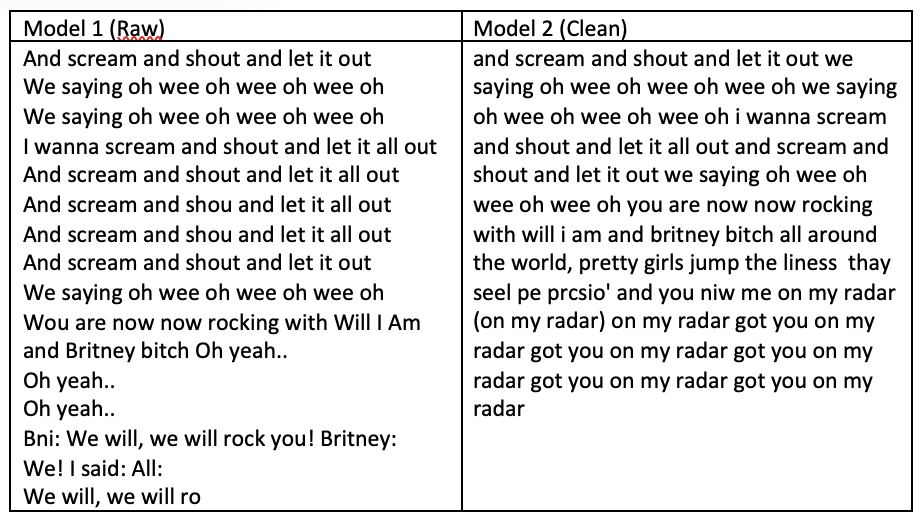


## **Generating text: trying on a test song**


We've tried to generate song lyrics based on Britney spears. For now, we have only tried generating on the train set. As seen in the report, the lyrics generated are quite close to the original lyrics. Now, we try to generate a Will I Am and Adelle song in the style of Britney Spears. If the generated model makes sense, then it could be a sign that our model is pretty good. If it does not make sense, it could be a sign that our model is overfitting.

In the following cells, we redo all the cleaning and preprocessing steps for the chorus of the song. Then we predict the next part of the song using the already-trained Britney Spear model.

In [ ]:
start2 = "Take me to New York, I'd love to see LA I really want to come kick it with you You'll be my American"
start2 = text_cleaning(start2)
print(start2)
len(start2)
string_mapped = list(start2)
start2_nbr= [char_to_n[value] for value in string_mapped]

print(start2_nbr)

take me to new york, i'd love to see la i really want to come kick it with you you'll be my american
[43, 24, 34, 28, 0, 36, 28, 0, 43, 38, 0, 37, 28, 46, 0, 48, 38, 41, 34, 7, 0, 32, 4, 27, 0, 35, 38, 45, 28, 0, 43, 38, 0, 42, 28, 28, 0, 35, 24, 0, 32, 0, 41, 28, 24, 35, 35, 48, 0, 46, 24, 37, 43, 0, 43, 38, 0, 26, 38, 36, 28, 0, 34, 32, 26, 34, 0, 32, 43, 0, 46, 32, 43, 31, 0, 48, 38, 44, 0, 48, 38, 44, 4, 35, 35, 0, 25, 28, 0, 36, 48, 0, 24, 36, 28, 41, 32, 26, 24, 37]


In [ ]:
for i in range(400):
    x = np.reshape(start2_nbr,(1,len(start2_nbr), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in start2_nbr]
    string_mapped.append(n_to_char[pred_index])
    
    start2_nbr.append(pred_index)  
    start2_nbr = start2_nbr[1:len(start2_nbr)] 

In [ ]:
txt=""
for char in string_mapped:
    txt = txt+char

print(start2)
print(txt)

take me to new york, i'd love to see la i really want to come kick it with you you'll be my american
take me to new york, i'd love to see la i really want to come kick it with you you'll be my americanedre you rain a mic bod in the sace oh my brdy ne you want mo more danc, cans, iat you tien amy (love me, hate me) ohhhh, say what you want about me ohhhh, but can't you see what i see? all of the boys and all of the girls are begging to if you seek amy (love me, hate me) ohhhh, say what you want about me ohhhh, but can't you see what i see? all of the boys and all of the girls are begging to if y


Let's try on another song that may be more suited to Britney Spear's style: Beyonce's "Single Ladies".



In [ ]:
start2 = "Don't be mad once you see that he want it If you liked it then you shoulda put a ring on it I got gl"
start2 = text_cleaning(start2)
print(start2)
print(len(start2))
string_mapped = list(start2)
start2_nbr= [char_to_n[value] for value in string_mapped]

print(start2_nbr)

don't be mad once you see that he want it if you liked it then you shoulda put a ring on it i got gl
100
[27, 38, 37, 4, 43, 0, 25, 28, 0, 36, 24, 27, 0, 38, 37, 26, 28, 0, 48, 38, 44, 0, 42, 28, 28, 0, 43, 31, 24, 43, 0, 31, 28, 0, 46, 24, 37, 43, 0, 32, 43, 0, 32, 29, 0, 48, 38, 44, 0, 35, 32, 34, 28, 27, 0, 32, 43, 0, 43, 31, 28, 37, 0, 48, 38, 44, 0, 42, 31, 38, 44, 35, 27, 24, 0, 39, 44, 43, 0, 24, 0, 41, 32, 37, 30, 0, 38, 37, 0, 32, 43, 0, 32, 0, 30, 38, 43, 0, 30, 35]


In [ ]:
for i in range(400):
    x = np.reshape(start2_nbr,(1,len(start2_nbr), 1))
    x = x / float(len(characters))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in start2_nbr]
    string_mapped.append(n_to_char[pred_index])
  
    start2_nbr.append(pred_index)  
    start2_nbr = start2_nbr[1:len(start2_nbr)] 

In [ ]:
txt=""
for char in string_mapped:
    txt = txt+char

print(start2)
print(txt)

don't be mad once you see that he want it if you liked it then you shoulda put a ring on it i got gl
don't be mad once you see that he want it if you liked it then you shoulda put a ring on it i got gl i don't nied nobody eren sp uo they goona de she one iat lak you fetty so love you got me hypnotized i move rhe guy mana i must confess, that my loneliness is killing me now don't you know i know that you know i know that you're a liar, a liar you can crawl, crawl, crawl you can beg and you can bleed baby talk, talk, talk keep on lying through your teeth you know i know that you know i know that 


Results of this experiment can be found in the README file in the Github report.